In [64]:
### import libraries

# format
import pandas as pd

# plot
import matplotlib.pyplot as plt
import seaborn as sns

# math
import numpy as np
import math
from scipy.linalg import inv, det
from numpy.linalg import eig

from scipy import stats


# Introduction
The following project documentation was written as work assignment for the module "Multivariate Analysis" of the Master in Statistics for Data Science at the Universidad Carlos III de Madrid. It contains the Multivariate Analysis of a Kaggel dataset on Sleep Health and Lifestyle (https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset). The work is split into to parts, where in a first part a exploratory data analysis is performed, where required,  data preprocessing steps are performed and a Prinicipal Component Analysis (PCA) is performed. In the second part, based on the learnings of part one, a (XXXXXXXXXXX) is performed to (XXXXXXXXX). 

In [65]:
# load data
data_raw = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")

 The dataset at hand is composed out of the collumns shown in the table below. It has been modified compared to the kaggle source data by turning the "Sleep Disorder" Variable into a binary variable (yes/no) and by seperating the blood pressure variables into the two variables blood pressure systolic and blood pressure diastolic.

| **Variable**                    | **Description**                                                                                              |
|---------------------------------|--------------------------------------------------------------------------------------------------------------|
| Person ID                       | An identifier for each individual.                                                                           |
| Gender                          | The gender of the person (Male/Female).                                                                      |
| Age                             | The age of the person in years.                                                                              |
| Occupation                      | The occupation or profession of the person.                                                                  |
| Sleep Duration (hours)          | The number of hours the person sleeps per day.                                                               |
| Quality of Sleep (scale: 1-10)  | A subjective rating of the quality of sleep, ranging from 1 to 10.                                          |
| Physical Activity Level (minutes/day) | The number of minutes the person engages in physical activity daily.                               |
| Stress Level (scale: 1-10)      | A subjective rating of the stress level experienced by the person, ranging from 1 to 10.                    |
| BMI Category                    | The BMI category of the person (e.g., Underweight, Normal, Overweight).                                      |
| Blood Pressure (systolic) | The blood pressure measurement of the person (systolic pressure)|
| Blood Pressure (diastolic) |  The blood pressure measurement of the person (diastolic pressure)|
| Heart Rate (bpm)                | The resting heart rate of the person in beats per minute.                                                    |
| Daily Steps                     | The number of steps the person takes per day.                                                                |
| Sleep Disorder                  | The presence or absence of a sleep disorder in the person (Binary)|

Furthermore some variable renaming and data type modifications are performed. All these preprocessing steps are performed in the following code chunk. 

In [85]:
data_raw.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [ ]:
### Preprocess Data
data = data_raw.copy()

rename_dict = {
    'Person ID':'person_id',
    'Gender': 'gender',
    'Age':'age',
    'Occupation':'occupation',
    'Sleep Duration':'sleep_duration',
    'Quality of Sleep':'quality_of_sleep',
    'Physical Activity Level':'physical_activity_level',
    'Stress Level':'stress_level',
    'BMI Category':'bmi_category', 
    'Blood Pressure':'blood_pressure', 
    'Heart Rate':'heart_rate', 
    'Daily Steps':'daily_steps',
    'Sleep Disorder':'sleep_disorder' 
}
data.rename(columns=rename_dict, inplace=True)

# change dtype
data['quality_of_sleep'] = data['quality_of_sleep'].astype(str)
data['stress_level'] = data['stress_level'].astype(str)

# make sleep disorder binary
data['sleep_disorder'] = data['sleep_disorder'].map(lambda x: '1' if x in ['Insomnia','Sleep Apnea'] else '0').astype(str)

# split blood pressure into diastolic & systolic
data[["blood_pressure_systolic","blood_pressure_diastolic"]] = data["blood_pressure"].str.split('/',expand=True)
data["blood_pressure_diastolic"] = pd.to_numeric(data['blood_pressure_diastolic'])
data["blood_pressure_systolic"] = pd.to_numeric(data["blood_pressure_systolic"])


data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   person_id                 374 non-null    int64  
 1   gender                    374 non-null    object 
 2   age                       374 non-null    int64  
 3   occupation                374 non-null    object 
 4   sleep_duration            374 non-null    float64
 5   quality_of_sleep          374 non-null    object 
 6   physical_activity_level   374 non-null    int64  
 7   stress_level              374 non-null    object 
 8   bmi_category              374 non-null    object 
 9   blood_pressure            374 non-null    object 
 10  heart_rate                374 non-null    int64  
 11  daily_steps               374 non-null    int64  
 12  sleep_disorder            374 non-null    object 
 13  blood_pressure_systolic   374 non-null    int64  
 14  blood_pres

# Part 1 - Exploratory Analysis and Dimension Reduction via PCA
As discussed in the introduction, the first part contains the initial exploratory analysis of the dataset as well as a PCA of the dataset.

In [67]:
# set up column lists
numeric_variables = ['age','sleep_duration','physical_activity_level','heart_rate','daily_steps','blood_pressure_systolic','blood_pressure_diastolic']
categorical_variable = ['gender','occupation','quality_of_sleep','stress_level','bmi_category','sleep_disorder']

data.head()

,person_id,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,blood_pressure,heart_rate,daily_steps,sleep_disorder,blood_pressure_systolic,blood_pressure_diastolic
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,0,126,83
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,0,125,80
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,0,125,80
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,1,140,90
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,1,140,90


TODO: Pairplot interpretation

[0.948209   0.9115284  0.96033816 0.25164604 0.98831354 0.76247781]


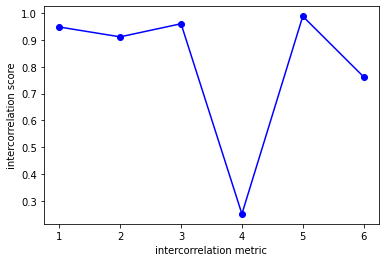

In [72]:
### Statistical Analysis & intercorrelation

means = data[numeric_variables].mean()
variances = data[numeric_variables].var()
df_covariance_matrix = data[numeric_variables].cov()
df_correlation_matrix = data[numeric_variables].corr()

def intercorrelations(X):
    n, p = X.shape
    R = np.corrcoef(X, rowvar=False)
    lambda_vals, _ = eig(R)
    rjj = np.diag(inv(R))
    q = np.zeros(6)
    q[0] = (1 - min(lambda_vals) / max(lambda_vals)) ** (p + 2)
    q[1] = 1 - p / np.sum(1. / lambda_vals)
    q[2] = 1 - np.sqrt(det(R))
    q[3] = (max(lambda_vals) / p) ** (3 / 2)
    q[4] = (1 - min(lambda_vals) / p) ** 5
    q[5] = np.sum((1 - 1. / rjj) / p)
    
    # print
    print(q)

    # plot
    plt.plot(range(1, 7), q, marker='o', linestyle='-', color='b', label='Intercorrelations')
    plt.xlabel("intercorrelation metric")
    plt.ylabel("intercorrelation score")
    return None


intercorrelations(data[numeric_variables])

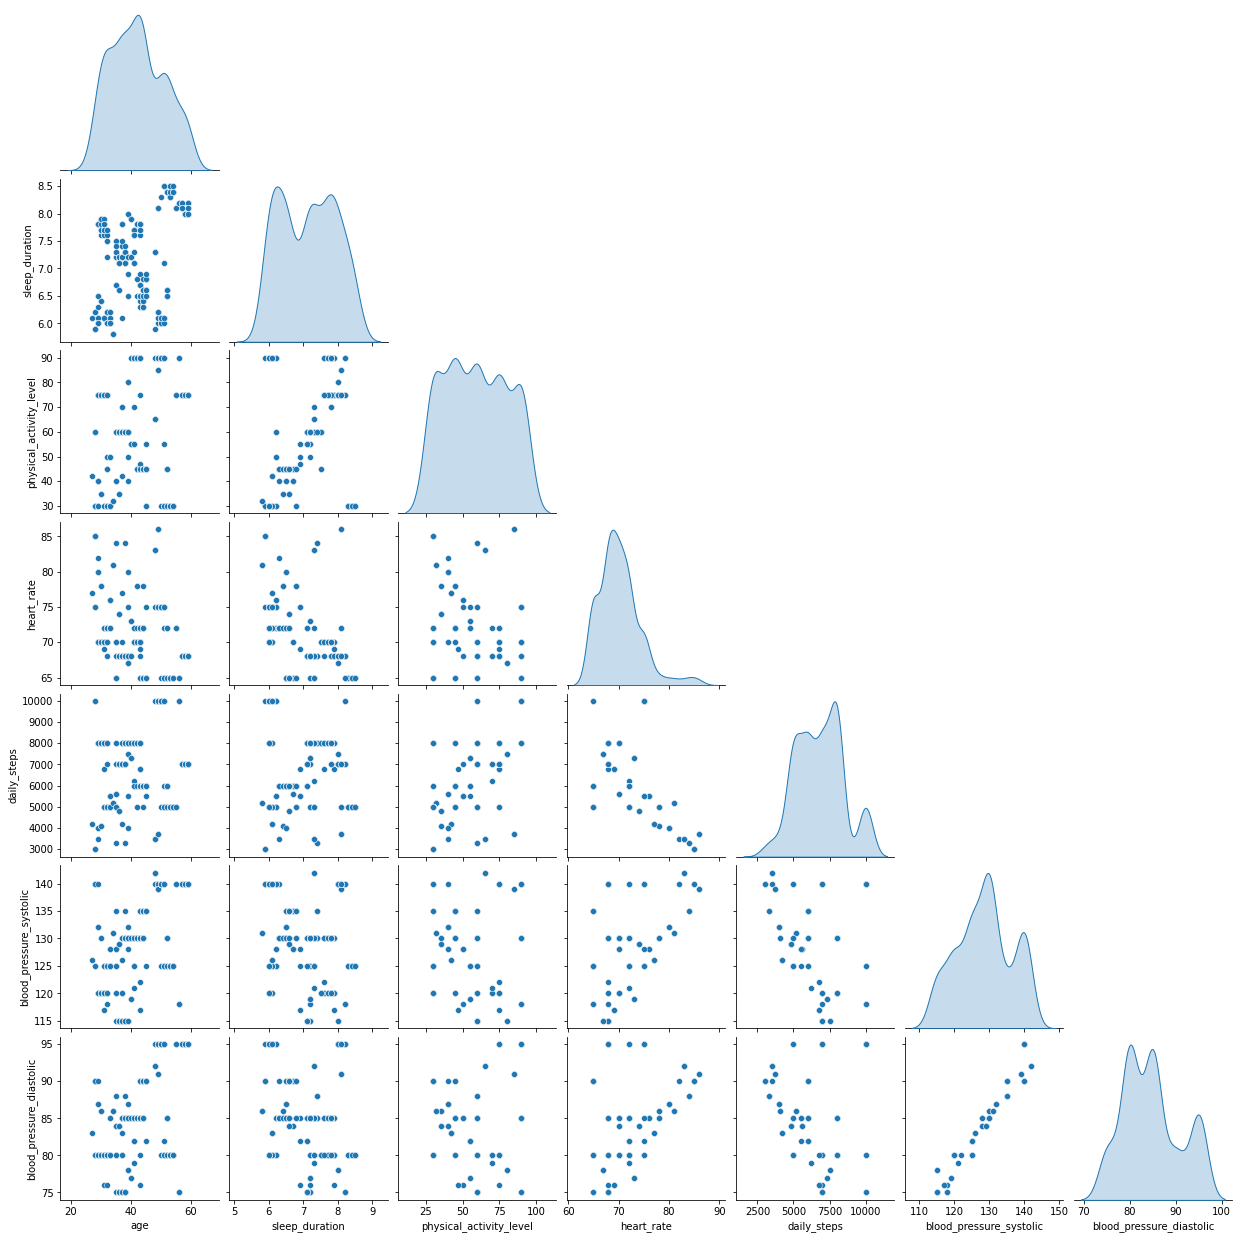

In [68]:
# pairplot
sns.pairplot(data[numeric_variables], diag_kind='kde', corner=True)
plt.show()

TODO: Correlation Matrix interpretation

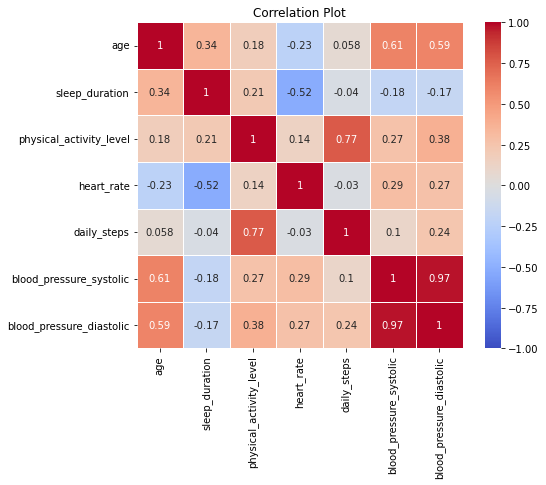

In [69]:
corr_mat = data[numeric_variables].corr()
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True, linewidths=0.5)
plt.title('Correlation Plot')
plt.show()

TODO: Histogram Interpretation

In [ ]:
def hist_box_plot(data, feature):
    fig, axs = plt.subplots(1,2, figsize=(10, 5))
    axs[0].hist(data[feature],bins=10,density=True,alpha=0.6,color='b',edgecolor="black")
    axs[0].set_title(f"Hist of {feature}")
    axs[1].boxplot(data[feature],vert=True, patch_artist=True,medianprops=dict(color="black"))
    axs[1].set_title(f"Boxplot of {feature}")
    plt.tight_layout(pad=2.0)


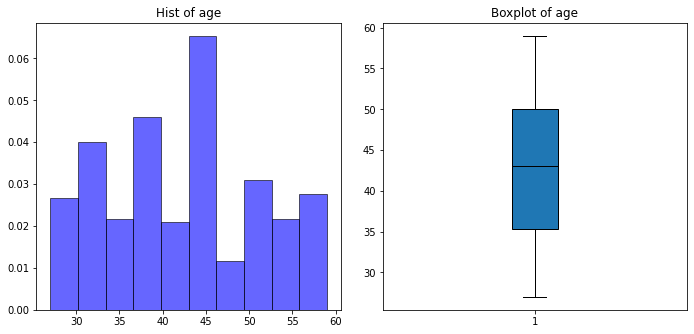

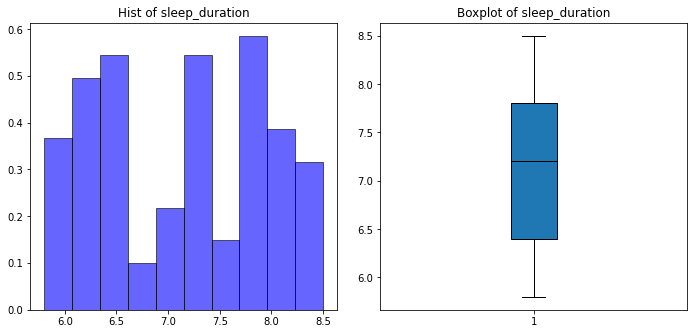

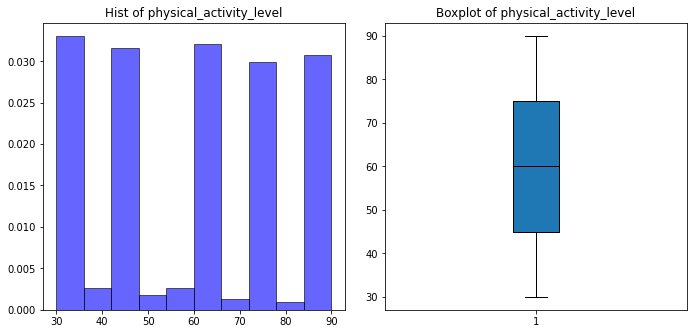

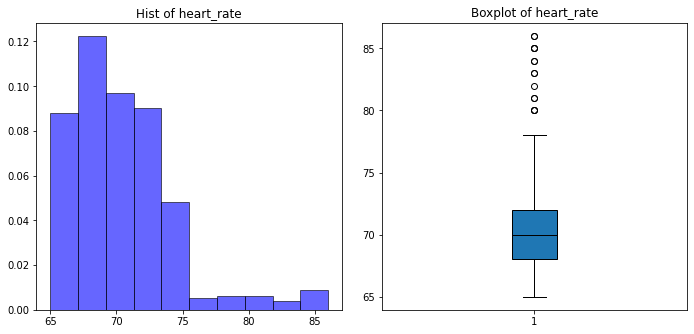

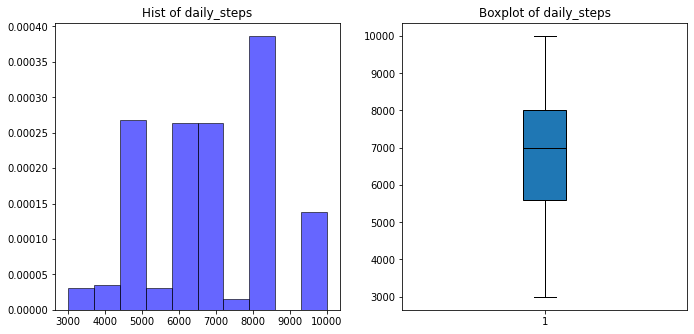

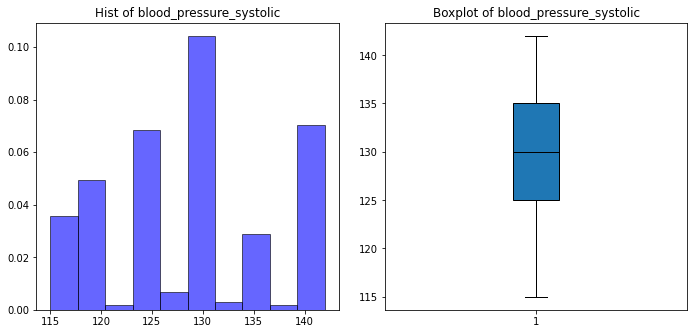

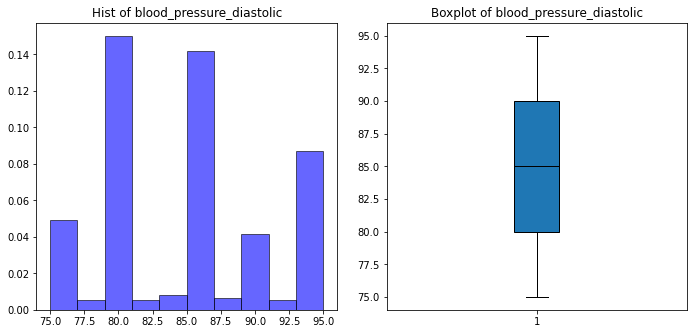

In [82]:
for numeric_variable in numeric_variables:
    hist_box_plot(data,numeric_variable)

In [ ]:
# TODO: Barplots
categorical_variable

TODO: Statistical Analysis & intercorrelation interpretation

In [73]:
# Function for plotting of conditional histograms 
def plot_categorical_hist(ncols,
                          numeric_variables,
                          categorical_variable,
                          host_stat='count',
                          figsize=(12, 10)
                          ):
    
    nrows = math.ceil(len(numeric_variables)/ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    for i, col in enumerate(numeric_variables):
        row = i // 2 
        col_pos = i % 2 
        sns.histplot(data=data, x=col, bins=10,hue=categorical_variable, kde=True, ax=axes[row, col_pos],stat=host_stat)
        axes[row, col_pos].set_title(f'Distribution of {col}')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

TODO: Conditiontal histograms interpretation

gender


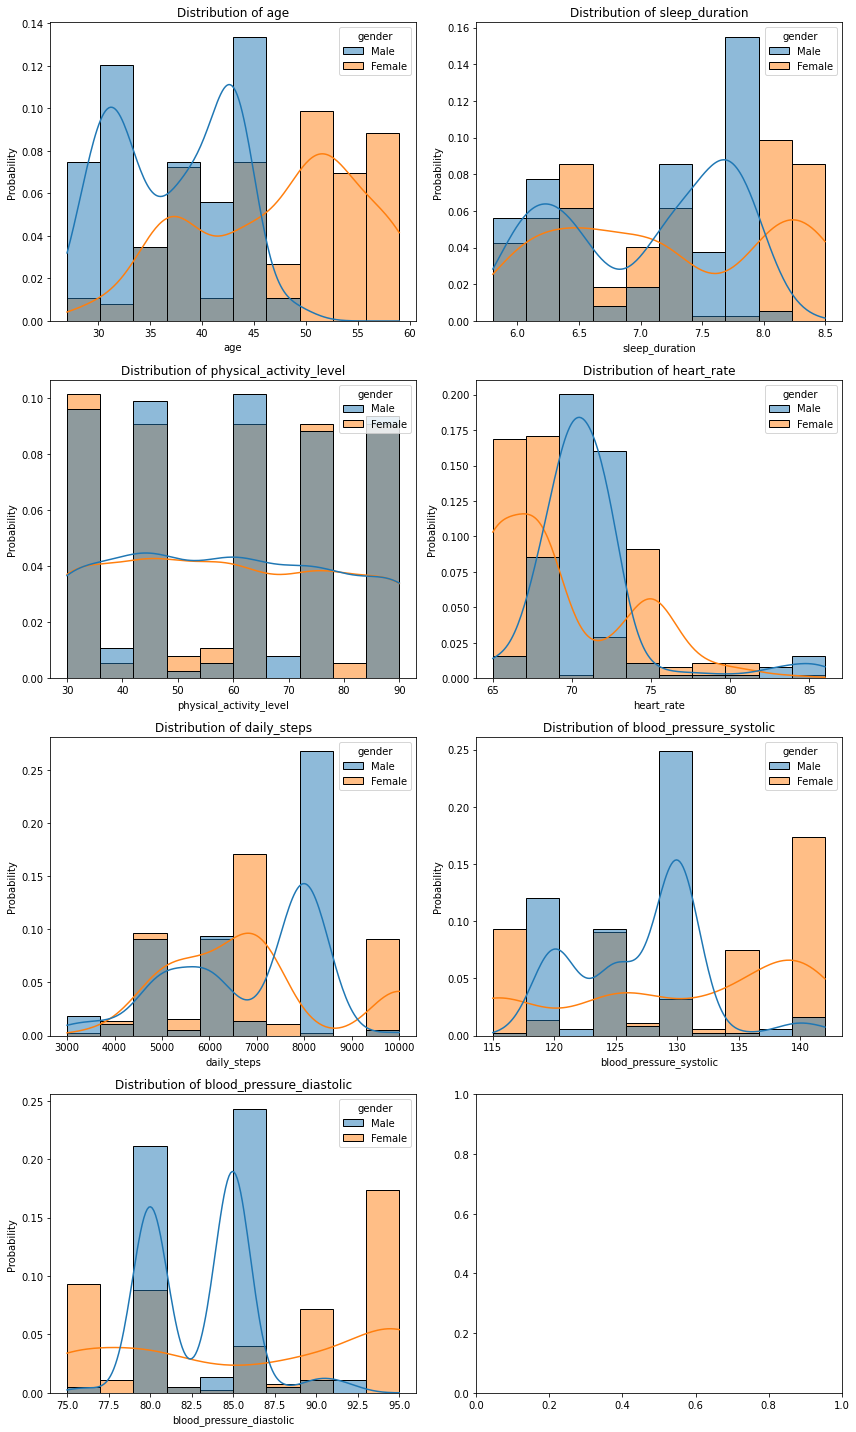

occupation


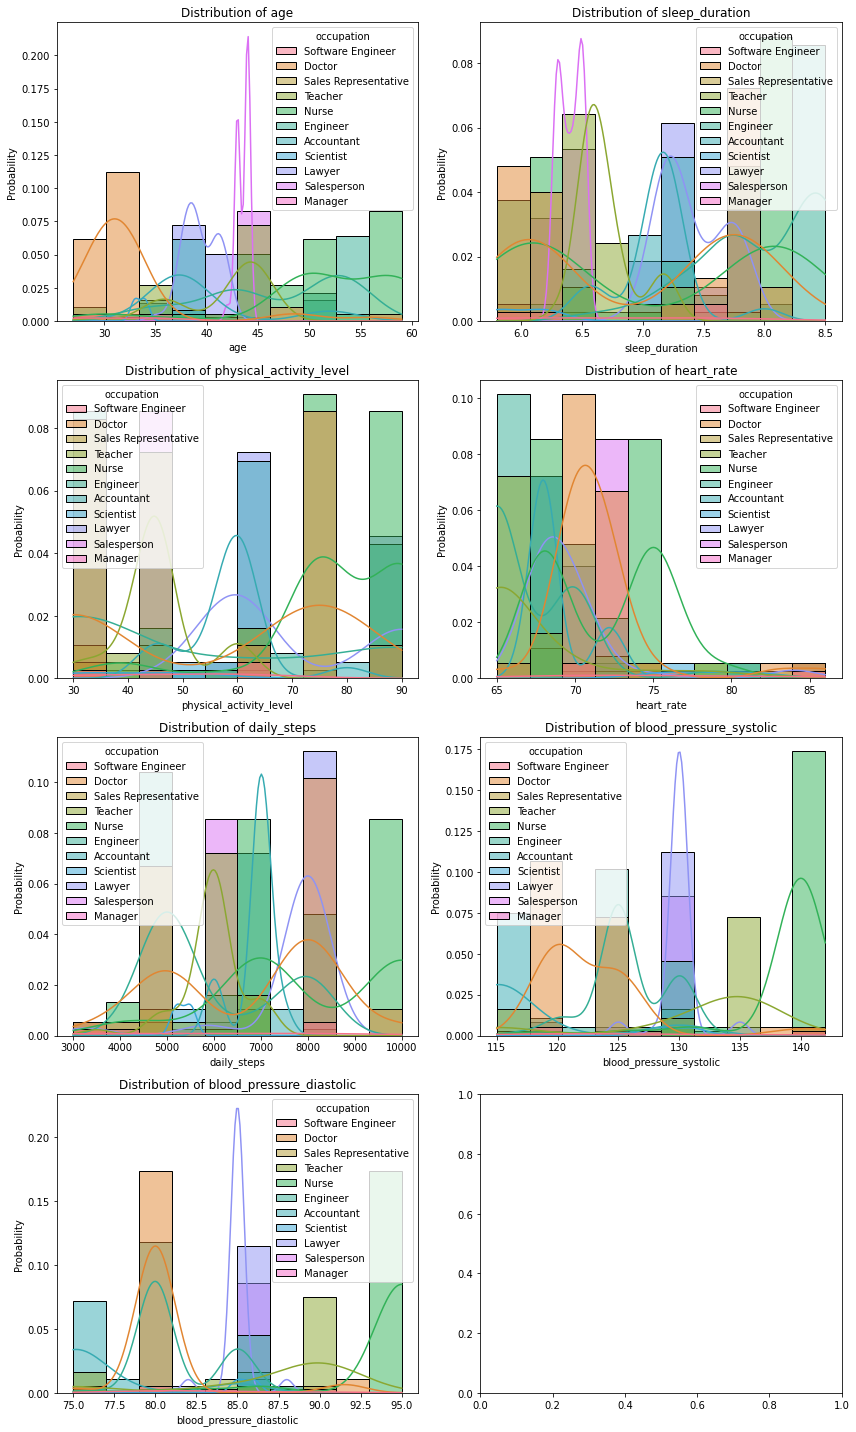

quality_of_sleep


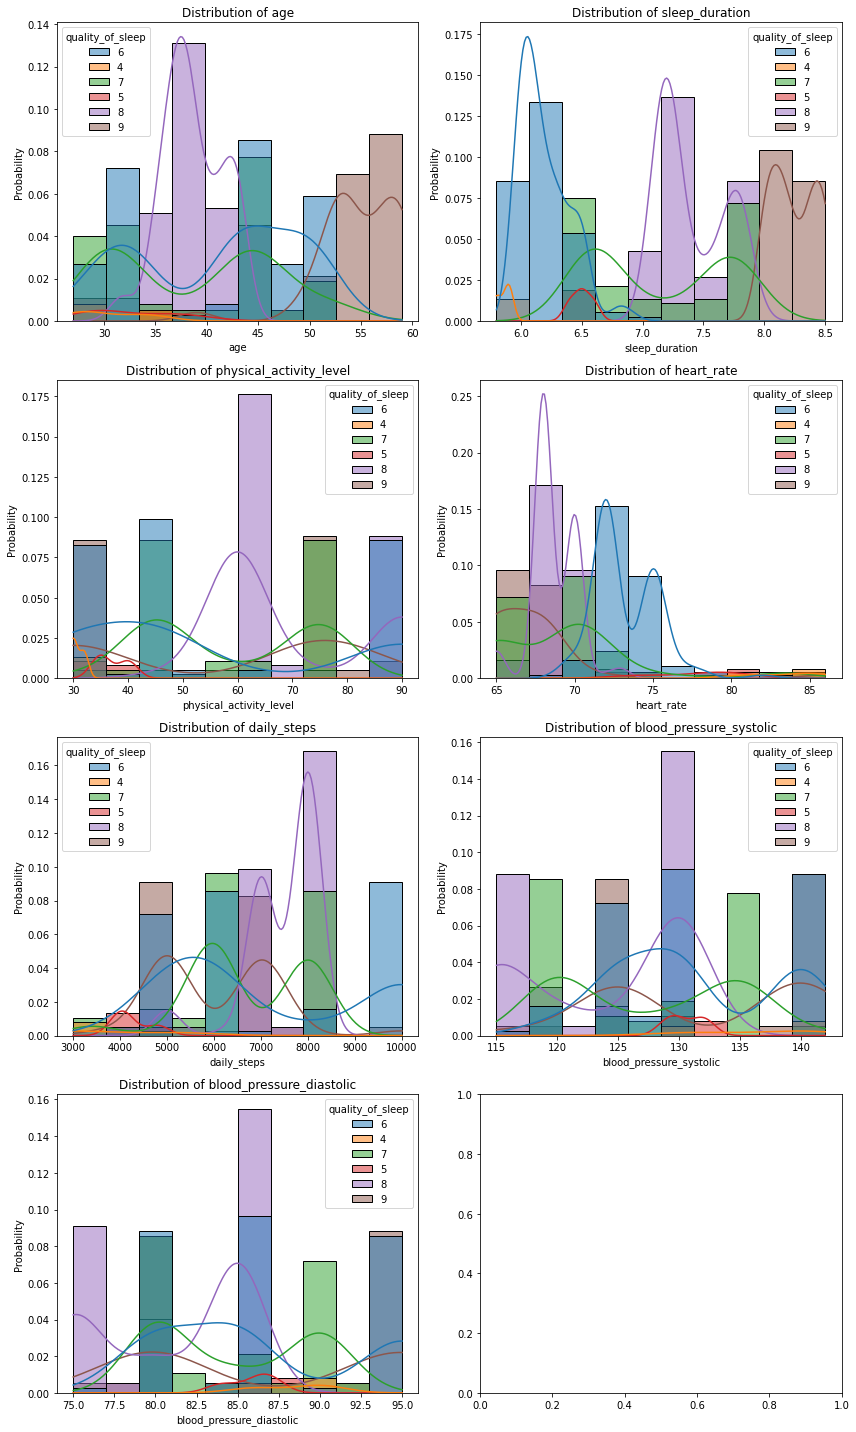

stress_level


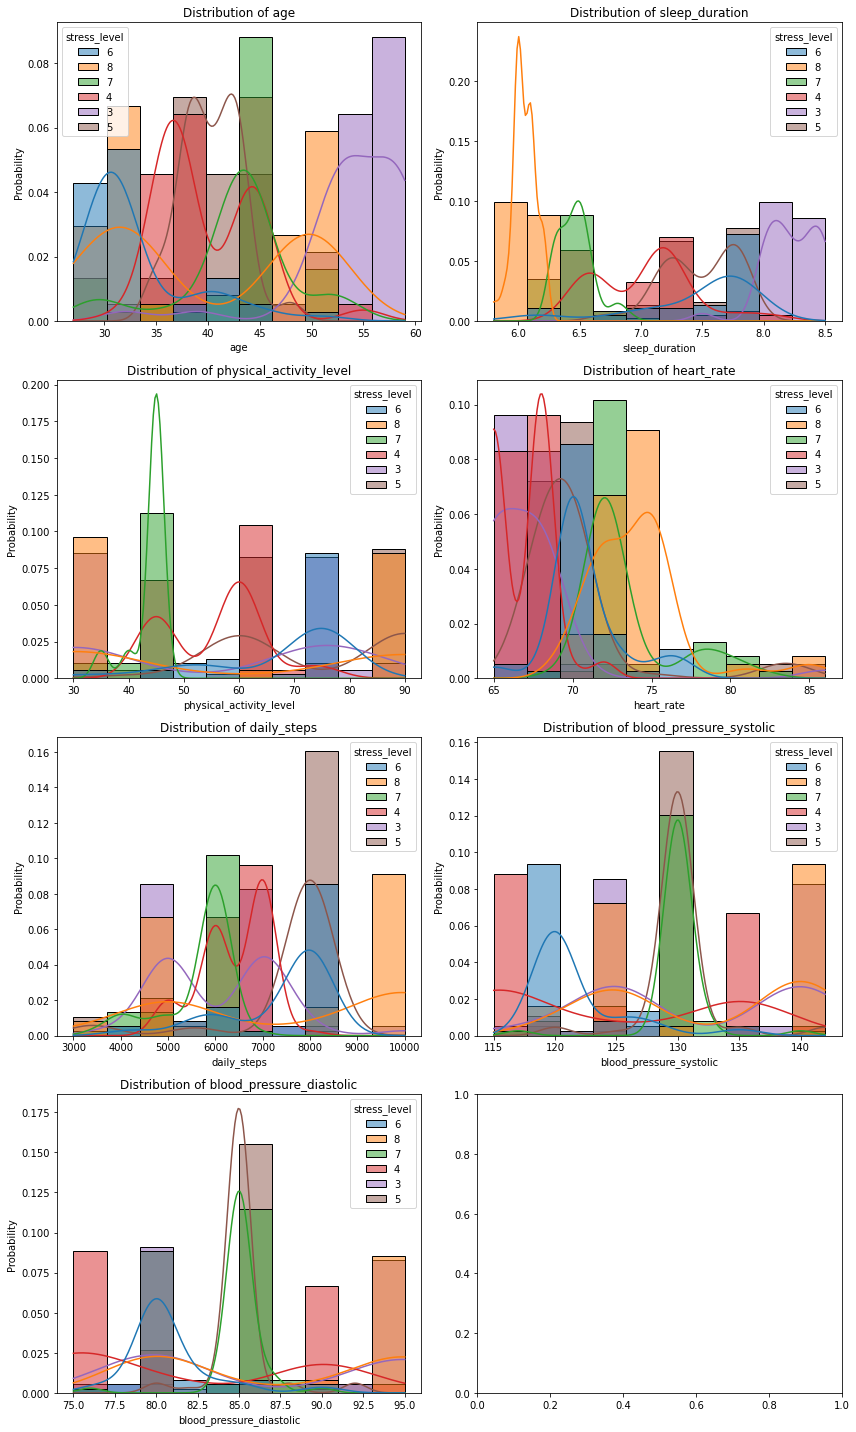

bmi_category


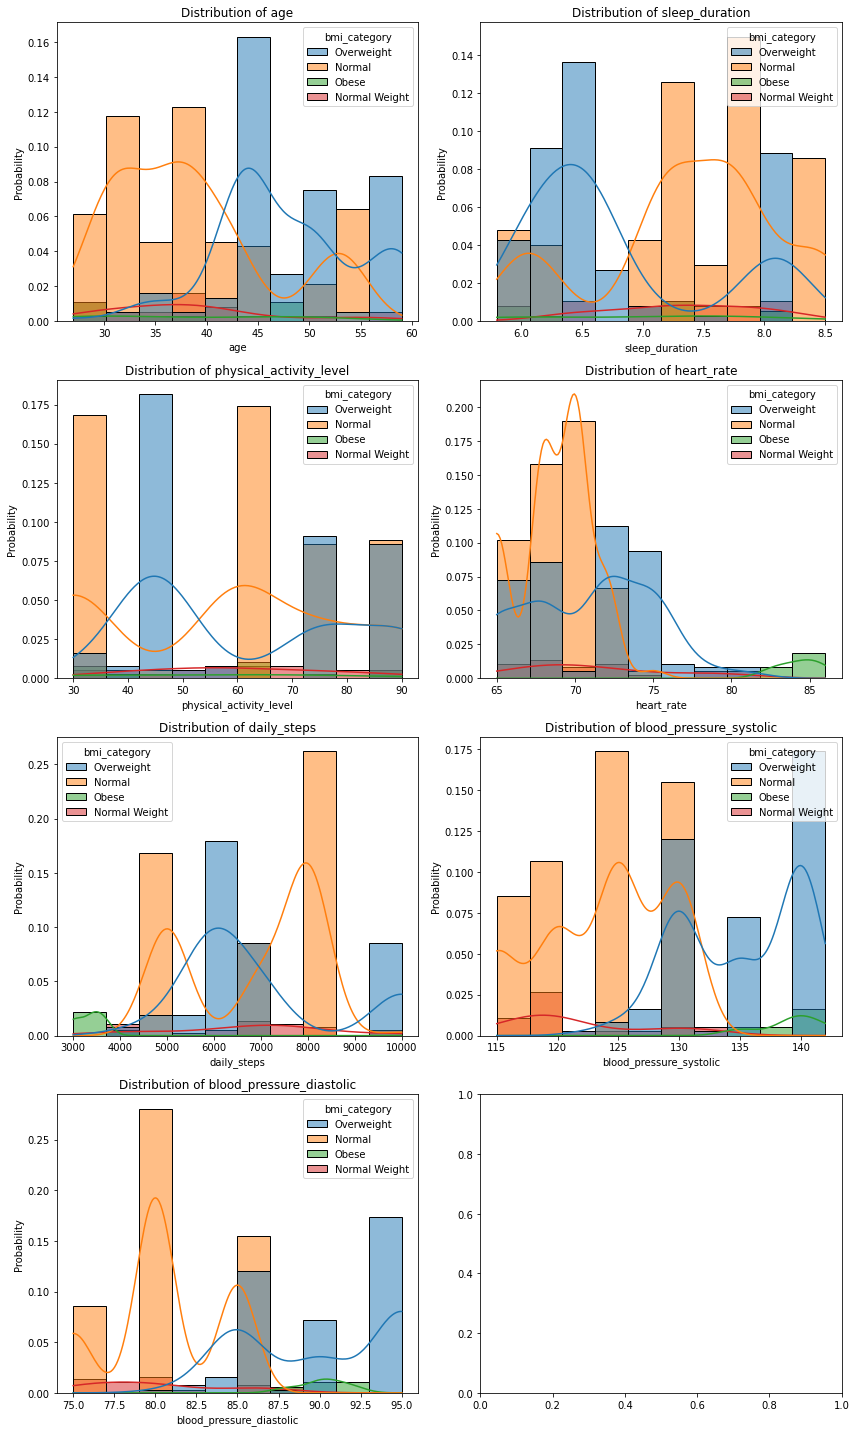

sleep_disorder


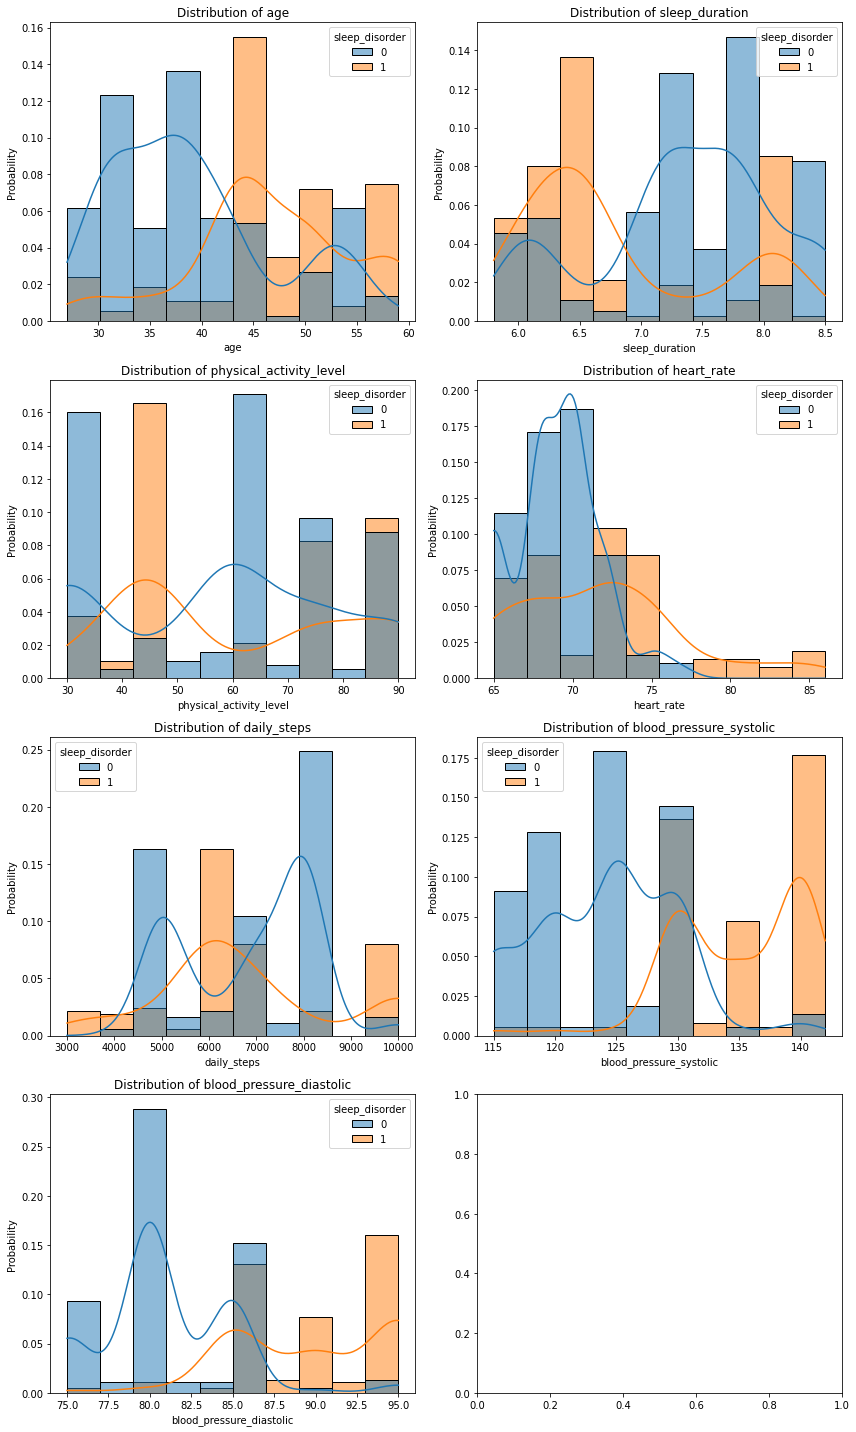

In [74]:
# TODO: Select relevant ones 
for categorical_variable in categorical_variable:
    print(categorical_variable)
    plot_categorical_hist(ncols=2,
                        numeric_variables=numeric_variables,#['calories_burned','session_duration_hrs','fat_percentage','avg_bpm'],
                        categorical_variable=categorical_variable,
                        host_stat='probability',
                        figsize=(12, 20))

## Outliers and Skewness

Only one variable has outliers and skewness problems (heart rate). And by cutting the outliers (4% of the DB), the skewness problem is corrected.

In [75]:
# print skewness
for i in numeric_variables:
    aux_skew = stats.skew(data[i])
    print(f"Skewness of {i} : {aux_skew}")

Skewness of age : 0.2561893511793312
Skewness of sleep_duration : 0.037403602518975176
Skewness of physical_activity_level : 0.07418782500797434
Skewness of heart_rate : 1.2199056700731632
Skewness of daily_steps : 0.17756151681455
Skewness of blood_pressure_systolic : -0.03552565092220491
Skewness of blood_pressure_diastolic : 0.37705009626387237


In [76]:
summary_stats = []

for i in numeric_variables:
    # Compute the descriptive statistics using scipy.stats.describe
    description = stats.describe(data[i])
    p90 = np.percentile(data[i], 90)
    p95 = np.percentile(data[i], 95)
    p99 = np.percentile(data[i], 99)

    # Store the results as a dictionary (with variable name as key)
    summary_stats.append({
        'Variable': i,
        'Count': description.nobs,
        'Min': description.minmax[0],
        'Mean': description.mean,
        'Percentile 90%': p90,
        'Percentile 95%': p95,
        'Percentile 99%': p99,
        'Max': description.minmax[1],
        'Variance': description.variance
    })

# Convert the list of dictionaries to a DataFrame for easier display
summary_df = pd.DataFrame(summary_stats)

# Display the summary statistics table
print(summary_df)


                   Variable  Count     Min         Mean  Percentile 90%  \
0                       age    374    27.0    42.184492            54.0   
1            sleep_duration    374     5.8     7.132086             8.2   
2   physical_activity_level    374    30.0    59.171123            90.0   
3                heart_rate    374    65.0    70.165775            75.0   
4               daily_steps    374  3000.0  6816.844920          8000.0   
5   blood_pressure_systolic    374   115.0   128.553476           140.0   
6  blood_pressure_diastolic    374    75.0    84.649733            95.0   

   Percentile 95%  Percentile 99%      Max      Variance  
0            58.0            59.0     59.0  7.522324e+01  
1             8.4             8.5      8.5  6.330696e-01  
2            90.0            90.0     90.0  4.339224e+02  
3            78.0            85.0     86.0  1.710381e+01  
4         10000.0         10000.0  10000.0  2.617651e+06  
5           140.0           140.0    142.0  6

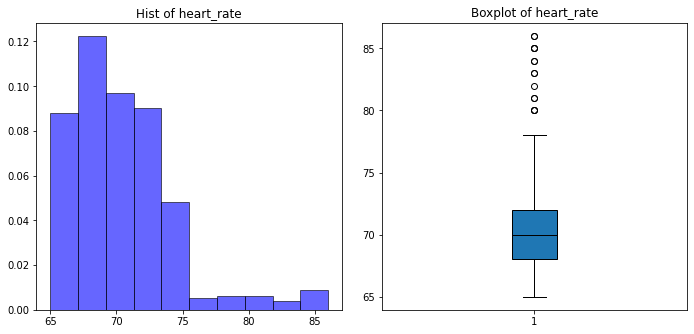

In [ ]:
hist_box_plot(data,"heart_rate")

In [78]:
for i in numeric_variables:
    q1 = np.percentile(data[i], 25)
    q3 = np.percentile(data[i], 75)
    RIC = q3 - q1 
    nout = np.sum(data[i] > (q3 + 1.5*RIC))
    print(f"The threshold for {i} upper outliers is  {q3 + 1.5*RIC}")
    print(f" then there are {nout} outliers in this variable, representing the {np.round(nout/374*100,2)} % of the dataset")

The threshold for age upper outliers is  72.125
 then there are 0 outliers in this variable, representing the 0.0 % of the dataset
The threshold for sleep_duration upper outliers is  9.899999999999999
 then there are 0 outliers in this variable, representing the 0.0 % of the dataset
The threshold for physical_activity_level upper outliers is  120.0
 then there are 0 outliers in this variable, representing the 0.0 % of the dataset
The threshold for heart_rate upper outliers is  78.0
 then there are 15 outliers in this variable, representing the 4.01 % of the dataset
The threshold for daily_steps upper outliers is  11600.0
 then there are 0 outliers in this variable, representing the 0.0 % of the dataset
The threshold for blood_pressure_systolic upper outliers is  150.0
 then there are 0 outliers in this variable, representing the 0.0 % of the dataset
The threshold for blood_pressure_diastolic upper outliers is  105.0
 then there are 0 outliers in this variable, representing the 0.0 % of

In [80]:
# temporary data while we have all the transformations
data_cut = data[data['heart_rate'] < 78] 

# CHECKING SKEWNESS AFTER CUTTING OUTLIERS
for i in numeric_variables:
    aux_skew = stats.skew(data_cut[i])
    print(f"Skewness of {i} : {aux_skew}")

Skewness of age : 0.2536214365138958
Skewness of sleep_duration : 0.007023536147360605
Skewness of physical_activity_level : 0.02433993825963072
Skewness of heart_rate : 0.207482395234077
Skewness of daily_steps : 0.38083630557334486
Skewness of blood_pressure_systolic : 0.01885717428155027
Skewness of blood_pressure_diastolic : 0.4513962755289981


In [ ]:
hist_box_plot(data_cut,"heart_rate")

## PCA

In [89]:
data

,person_id,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,blood_pressure,heart_rate,daily_steps,sleep_disorder,blood_pressure_systolic,blood_pressure_diastolic
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,0,126,83
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,0,125,80
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,0,125,80
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,1,140,90
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,1,140,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,370,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,1,140,95
370,371,Female,59,Nurse,8.0,9,75,3,Overweight,140/95,68,7000,1,140,95
371,372,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,1,140,95
372,373,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,1,140,95


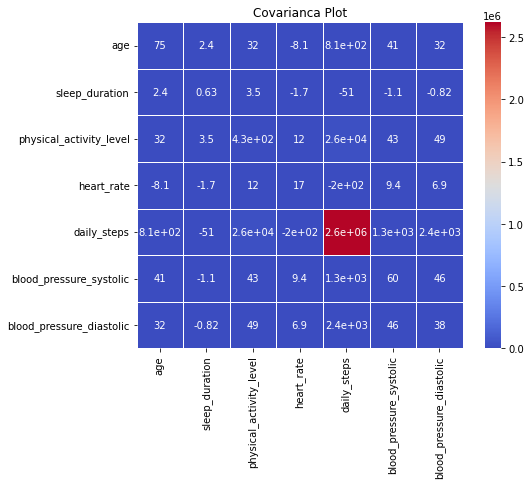

In [92]:
corr_mat = data[numeric_variables].cov()
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Covarianca Plot')
plt.show()

In [ ]:
# TODO: Standardize x-mue/sd